# Progressive Pulse Compression

## Introducción

Rango ciego (blind range) es la porción de la ventana de rango, cercana al radar, que se encuentra obscurecida por la filtración de energía directamente desde el transmisor al receptor, debido a que la aislación entre estos  dispositivos no es perfecta. El tamaño de la región de rango ciego es 

$$ R_b = \frac{c\tau_p}{2} $$

donde $\tau_p$ es la duración del pulso.

La técnica compression de pulso progresiva (PPC - progressive pulse compression) utiliza la parte de la señal de radar que no fue contaminada por la energía filtrada desde el transmisor. Dado que la señal sin comprimir es larga, se espera que objetivos ubicados en el zona rango ciego generen ecos con colas que se extienden por fuera de esa zona. Esta parte de la cola se puede utilizar para detectar objetivos dentro del rango ciego. 

La técnica PPC se describe en [1] para radares meteorológicos cuyos transmisores se basan en tecnología de estado solido y deben transmitir pulsos largos para lograr las condiciones necesarias de sensibilidad (o detectabilidad). Sin embargo, esta técnica puede ser utilizada en otro tipo de radar que use modulación en frecuencia para la compresión de pulso. 

### Ventajas
* Simple de implementar
* No necesita ancho de banda adicional

### Desventajas
* La resolución en rango desmejora a medida que decrece el rango.
* Existe un corrimiento del pico de la respuesta del filtro adaptado y el corrimiento es mayor a medida que decrece el rango.

## Algoritmo PPC

La técnica de compresión PPC consiste en tres pasos
1. Anular la región de rango ciego
2. Utilizar codificación parcial y compresión
3. Calibrar

El término *compresión parcial* se usa para representar el proceso de compresión de la cola de un eco generado por un objetivo ubicado en el rango ciego, descartando el tramo de datos contaminados por la filtración de energía.

### 1. Anulación de datos contaminados
Los datos $y_n$ recolectados a la salida del receptor en el dominio de tiempo rápido (equivalente a rango) se multiplican por la ventana $w_n$ diseñada para eliminar la energia en la región de rango ciego. La secuencia resultante es 

$$y_n' = w_n y_n$$

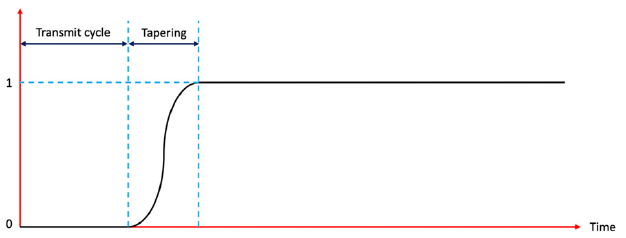

Fig.: Ilustración de la ventana utilizada para eliminar la filtración de energía, con una transición gradual (tapering) de cero a uno después del rango ciego (fuente [1]).

### 2. Codificación parcial
La respuesta impulsional del filtro adaptado a la señal $x_n$ es $h_n=x^*_{N-1-n}$ para $n = 0, \ldots ,N_p-1$ con $N_p= \lfloor \tau_p F_s \rfloor$. La señal de salida del filtro adaptado, o el resultado de la codificación parcial, es 

$$\begin{align}
z_n &= h_n \star y_n' =  \sum_{m=-\infty}^{\infty} h_{m} y_{n-m}' \\
&= \sum_{m=0}^{N_p-1} x^*_{N_p-1-m} y_{n-m}'
\end{align}$$

La secuencia $z_n$ se define como la señal de compresión progresiva. 

### 3. Calibración
La respuesta del filtro adaptado debe compensarse o calibrarse para compensar la energía que se pierde la procesar una fracción del eco por medio de la compresión progresiva. La respuesta del filtro adaptado se amplifica para celdas de rango cercano

$$z_n = s_n \sum_{m=0}^{N_p-1} x^*_{N_p-1-m} y_{n-m}'$$

donde el factor de escala es 

$$s_n = \frac{\sum_{i=n}^{n+N-1}|h_i|^2}{\sum_{i=n}^{n+N-1}|w_i h_i|^2} $$

siendo $N = N_p + N_t$ la cantidad de celdas de rango $N_p$ de la región de rango ciego más la cantidad de celdas de rango $N_t$ de la región de transición (tapering).

#### Nota
* La expresión de los coeficientes $s_n$ definida en la ecuación (7) de [1] discrepa de la presentada anteriormente. En [1] se propone utilizar la raiz cuadrada de los coeficientes.

## Implementación y Simulación

### Receptor
* Ancho de banda máximo del canal $BW_{ch} = 2.5$ MHz
* Frecuencia de muestreo a la salida del receptor $F_s = 25$ MHz

### Señal LFM y NLFM
* Forma de onda chirp
* Amplitud $A = 1$
* Ancho de banda $B = 1.25$ MHz
* Duración de la señal $T_p = 66.71 \mu$ s ( $10$ km)
* Factor de compresión BT $=83.39$

Para utilizar las señales NLFM se llama al módulo donde se encuentran presentes 3 tipos de modulación no lineal junto con la función que permite comparar estos pulsos con el pulso chirp. Para más información referirse al notebook PulsosNLFM.ipynb.

In [38]:
import numpy as np
from importnb import imports
with imports("ipynb"):
    import PulsosNLFM as NLFM

In [39]:
NLFM.Analisis_NLFM()

interactive(children=(IntSlider(value=1, description='Modulacion', max=3, min=1), FloatSlider(value=66.71, des…

In [63]:
def chirp_signal(A, T, fs, B,Chirp_NLFM,k):
    '''
    Sintetiza datos correspondiente a una señal chirp.
    
    Parameters:
    ---
    A: float
        Amplitud de la señal.
    T: float
        Duración del pulso [s].
    fs: float
        Frecuencia de muestreo [Hz].
    B: float
        Ancho de banda [Hz].
    Chirp_NLFM : 
        Selecciona chirp (0) o NLFM (1).
    Returns:
    ---
    S: array, cfloat
        Envolvente compleja de la señal.
    t: array
        Tiempo (variable independiente).
    '''
    # Parametros
    ts = 1/fs # Tiempo de muestreo               
    Nsim = int(np.ceil(T/ts)) # Cantidad de muestras
    t = np.linspace(0, Nsim - 1, Nsim)*ts # Escala de tiempo
    if(Chirp_NLFM == 1):
        
        # Vector de frecuencia
        fnlfm3 = NLFM.NLFM_3(B, T, 1/fs, k, 0)
        # Fase de la señal
        S_phase = 2*np.pi*np.cumsum(fnlfm3[0:np.size(fnlfm3) - 1])/fs

    else:
        f_i = -B/2
        f_e = B/2
        # fase de la señal
        S_phase = 2 * np.pi * (B*np.square(t)/(2*T) + f_i*t)
    # pulso
    S = A * np.exp(1j*S_phase)
    return S, t

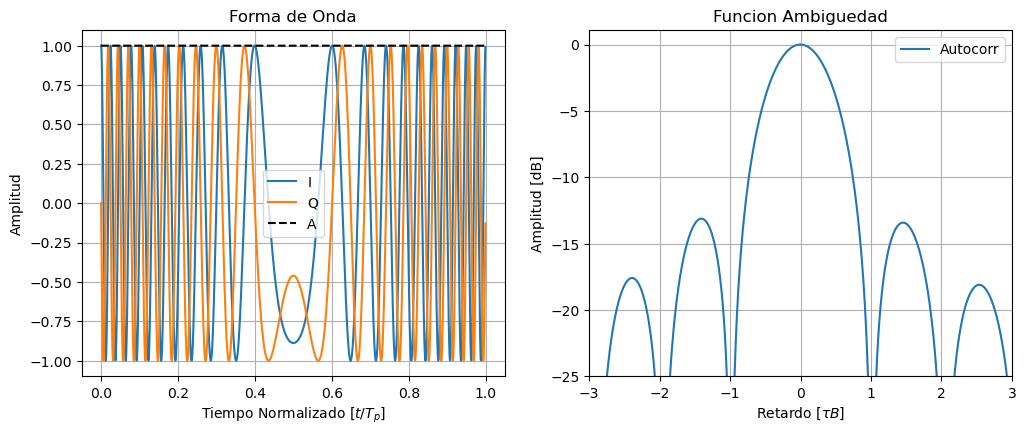

In [65]:
# Parametros de la chirp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, convolve
from scipy.constants import speed_of_light

# Seleccion de pulso 
    	# Seleccion_pulso = 0 -> Pulso chirp
        # Seleccion_pulso = 1 -> Modulacion no lineal
Seleccion_pulso = 0

# Parametros del sistema
BWch = 2.5E6 # Ancho de banda del canal
Fs = 25E6 # Frec de muestreo

# Forma de onda del radar
A = 1 # Amplitud
B = 1.25E6 # Ancho de banda
Tp = 2*10E3/speed_of_light # Duracion
BT = B*Tp # factor de compresion
Sx,t_x = chirp_signal(A, Tp, Fs, B,Seleccion_pulso,0.17)
Ex = np.sum(np.abs(Sx)**2)

# Autocorrelacion
t_a = np.arange(-3/B, 3/B, 1/Fs/10)
Ra = np.ones(len(t_a))
msk = np.where( t_a!=0 )
Ra[msk] = np.abs( np.sin(np.pi*B*t_a[msk]*(1-t_a[msk]/Tp))/(np.pi*B*t_a[msk]) )


# Grafico
fig, ax = plt.subplots(1,2, figsize=(6*2,6*.75))
ax[0].plot(t_x/Tp, np.real(Sx), label='I')
ax[0].plot(t_x/Tp, np.imag(Sx), label='Q')
ax[0].plot(t_x/Tp, np.abs(Sx), label='A', color='black', linestyle='dashed')
ax[0].set_xlabel(r'Tiempo Normalizado [$t/T_p$]')
ax[0].set_ylabel('Amplitud')
ax[0].set_title('Forma de Onda')
ax[0].legend()
ax[0].grid(True)
ax[1].plot(t_a*B, 20*np.log10(Ra), label='Autocorr')
ax[1].set_xlabel(r'Retardo [$\tau B$]')
ax[1].set_ylabel('Amplitud [dB]')
ax[1].set_title('Funcion Ambiguedad')
ax[1].axis([-3, 3, -25, 1.1])
ax[1].legend()
ax[1].grid(True)
plt.show()

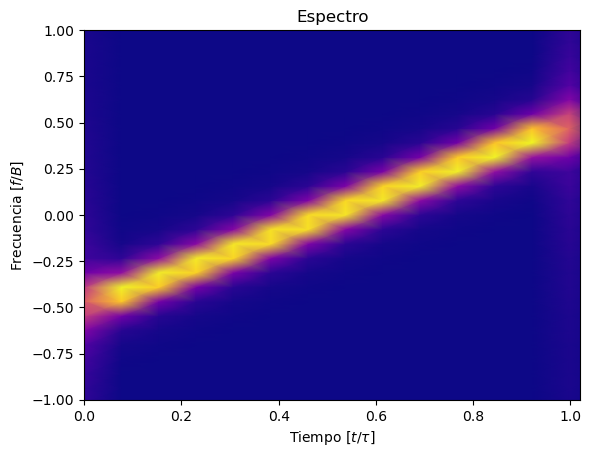

In [66]:
# Espectrograma
if True: 
    from scipy.signal import stft
    Sc,Tc = chirp_signal(A, Tp, Fs, B, Seleccion_pulso, 0.17)
    fo, to, Pc = stft(Sc, Fs, nperseg=256, return_onesided=False) 
    fo = np.fft.fftshift(fo)
    Pc = np.fft.fftshift(Pc, axes=0)
    plt.pcolormesh(to/Tp, fo/B, np.abs(Pc), cmap='plasma', shading='gouraud')
    plt.xlim(0, 1.02)
    plt.ylim(-1, 1)
    plt.ylabel('Frecuencia [$f/B$]')
    plt.xlabel(r'Tiempo [$t/\tau$]')
    plt.title('Espectro')
    plt.show()

## Modelo de ecos
* Largo del pulso $R_p = 10$ km
* Rango ciego $R_b = 10$ km
* Rango inicial $R_1 = 1$ km
* Rango final $R_2 = 30$ km
* Celda de rango $\Delta R_s = 60$ m
* Resolución en rango $\Delta R = 120$ m

In [67]:
# Generar un eco de objetivo puntual estatico
Rp = speed_of_light*Tp/2 # Largo pulso
Rb = Rp # Rango ciego
R1 = 1E3 # Rango minimo
R2 = 30E3 # Rango maximo
DRs = speed_of_light/2/Fs # Celda de rango
DR = speed_of_light/2/B # Resolucion en rango

# Largo de secuencias
Np = int((2*Rp/speed_of_light)*Fs)
N1 = int((2*R1/speed_of_light)*Fs)
N2 = int((2*R2/speed_of_light)*Fs)
Ndata = int((2*R2/speed_of_light + Tp)*Fs)

# Señal ruido
sigma2 = 1 
Sy = ( np.random.normal(0, 1, (Ndata)) + 1j*np.random.normal(0, 1, (Ndata)) )*np.sqrt(sigma2/2)

#  Señal eco de objetivo
SNR = 0
A = np.sqrt( sigma2*10**(SNR/10) )
Rt = 3E3 
Nt = int((2*Rt/speed_of_light)*Fs)
Sy[Nt:(Nt+Np)] += A*Sx[:Np]

# Señal interferencia
INR = 40
I = np.sqrt( sigma2*10**(INR/10) ) 
Sy[:Np] = I*np.ones(Np)*(1+1j)/np.sqrt(2)

## Salida del receptor
* Secuencia de datos a salida del receptor, en banda base, previo a compresión de pulso o filtro adaptado

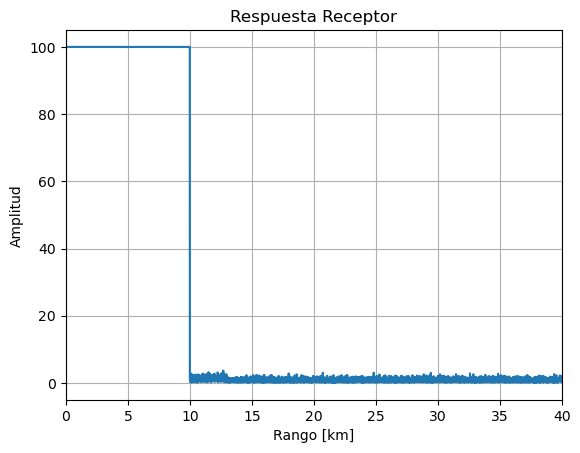

In [68]:
# Señal respuesta receptor
r_y = np.arange(0, Ndata)*DRs
plt.plot(r_y*1E-3, np.abs(Sy) )
plt.xlim(0, (R2+Rp)*1E-3)
plt.xlabel('Rango [km]')
plt.ylabel('Amplitud')
plt.title('Respuesta Receptor')
plt.grid(True)
plt.show()

## Salida del filtro adaptado
* Secuencia de datos a la salida del filtro adaptado

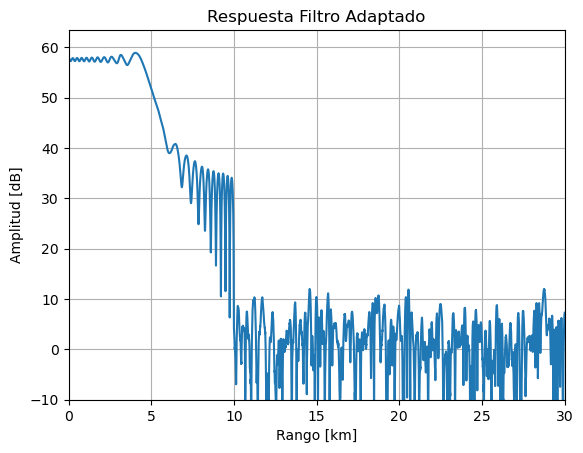

Posicion del pico: 4.04km


In [69]:
# Señal respuesta filtro adaptado
Sz = np.abs( fftconvolve(Sy, np.conj(Sx), mode='full') )/(Fs*1E-6)
r_z = np.arange(0, Ndata+Np)*DRs
plt.plot((r_z-Rp)*1E-3, 20*np.log10(Sz) )
plt.xlim(0, R2*1E-3)
plt.ylim(-10)
plt.xlabel('Rango [km]')
plt.ylabel('Amplitud [dB]')
plt.title('Respuesta Filtro Adaptado')
plt.grid(True)
plt.show()

# Localizar el pico
ind = np.where( Sz==np.amax(Sz) )
print('Posicion del pico: {:.2f}km'.format((r_z[ind[0][0]]-Rp)*1E-3))

## Ventana
* Ventana diseñada para eliminar o anular la señal en la zona de rango ciego

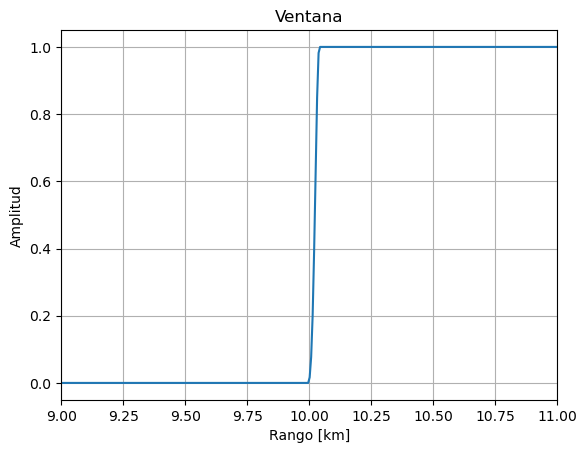

In [70]:
# Ventana
Ntp = 2*int(.005*Np/2)
W = np.ones(Ndata)
W[:Np] = np.zeros(Np)
W[Np:(Np+Ntp)] = np.blackman(2*Ntp)[:Ntp]
plt.plot(r_y*1E-3, W)
plt.xlim(9, 11)
plt.xlabel('Rango [km]')
plt.ylabel('Amplitud')
plt.title('Ventana')
plt.grid(True)
plt.show()

### Nota
* El diseño de la transición (tapering) permite reducir los lóbulos secundarios de la función ambiguedad, a expensas de un ensanchamiento del lóbulo principal.

## Calibración
* Factor de escala o ponderación contemplando que la compresión progresiva procesa una fracción del eco

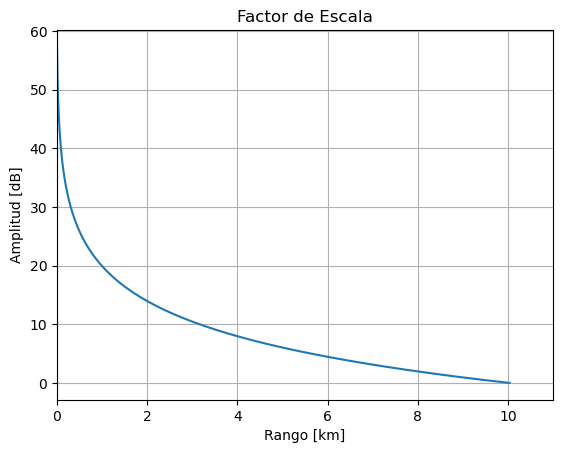

In [71]:
H = np.append(Sx, np.ones(int(1.5*Np))) 
X = np.ones(Np+Ntp)
Num = np.abs( convolve(np.abs(H)**2, X, mode='valid') )
Den = np.abs( convolve(np.abs(W[:len(H)]*H)**2, X, mode='valid') )
C = (Num/Den)
ind = np.where(C==1)
C = C[:ind[0][0]]
plt.plot(np.arange(len(C))*DRs*1E-3, 20*np.log10(C))
plt.xlim(0, 11)
plt.xlabel('Rango [km]')
plt.ylabel('Amplitud [dB]')
plt.title('Factor de Escala')
plt.grid(True)
plt.show()

## Algoritmo PPC
* Procesamiento de datos sintéticos y resultados de la técnica PPC 

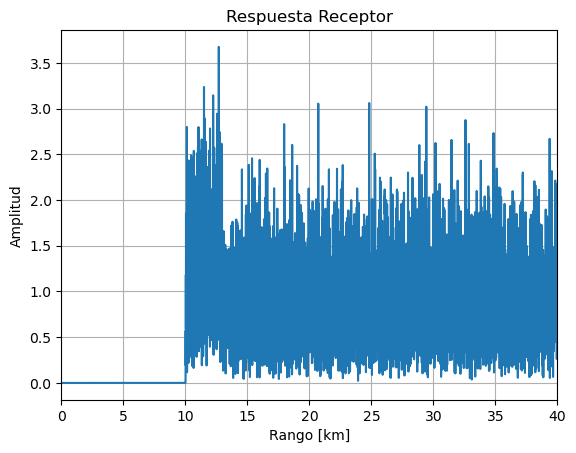

In [74]:
# Señal ventaneada
Sy *= W
plt.plot(r_y*1E-3, np.abs(Sy) )
plt.xlim(0, (R2+Rp)*1E-3)
plt.xlabel('Rango [km]')
plt.ylabel('Amplitud')
plt.title('Respuesta Receptor')
plt.grid(True)
plt.show()

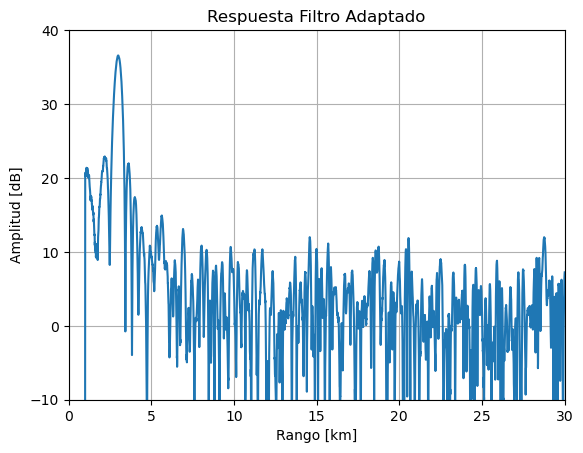

Posicion del pico: 2.99km


In [75]:
# Señal respuesta codificacion parcial
Sz = np.abs( fftconvolve(Sy, np.conj(Sx), mode='full') )/(Fs*1E-6)
Sz = Sz[Np:]
Sz[:len(C)] *= C
Sz[:N1] = np.amin(Sz) 
plt.plot(r_y*1E-3, 20*np.log10(Sz) )
plt.xlim(0, R2*1E-3)
plt.ylim(-10, 40)
plt.xlabel('Rango [km]')
plt.ylabel('Amplitud [dB]')
plt.title('Respuesta Filtro Adaptado')
plt.grid(True)
plt.show()

# Localizar el pico
ind = np.where( Sz==np.amax(Sz) )
print('Posicion del pico: {:.2f}km'.format(r_y[ind[0][0]]*1E-3))

## Análisis
* A partir de datos sintéticos, con la presencia de ecos de un objetivo puntual contaminados por ruido blanco e interferencia en la región de rango ciego, se analiza la posición del pico de señal a la salida del filtro adaptado, la amplitud del pico, y la resolución en rango

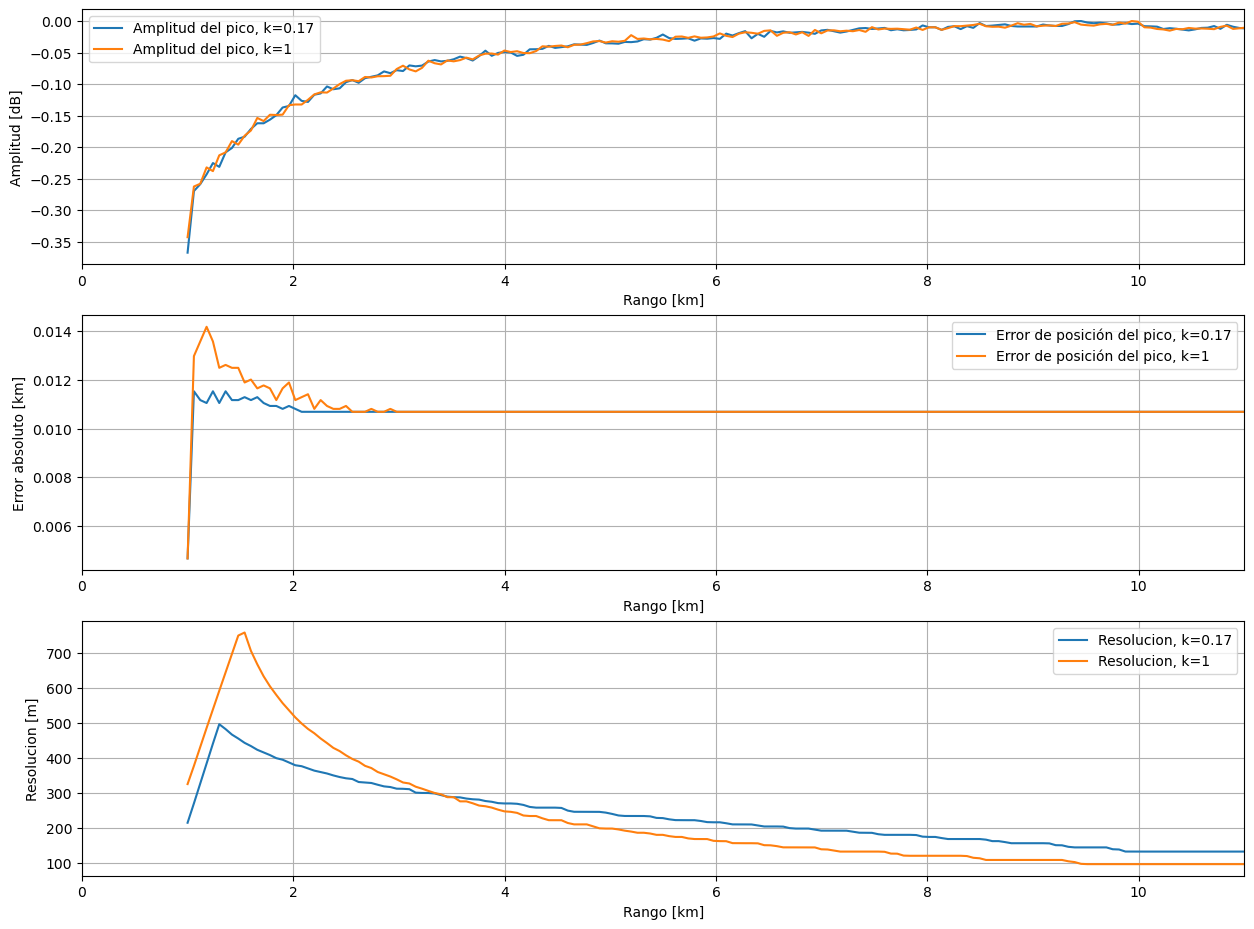

In [81]:

modulacion = np.arange(0,2)
# k: Factor de alinealidad 
K = np.arange(0,5)
K= K / max(K) 
K=[0.17, 1]
fig, ax = plt.subplots(3,1, figsize=(15,3.75*3))

Kb = 1.2 # Expansion del ancho de banda obtenida con la herramienta de analisis de pulsos no lineales para NLFM3

for kk in K:
    
    Range_Target = np.arange(1E3, 15E3, 10*DRs)
    Pico = np.zeros(len(Range_Target))
    PicoPos = np.zeros(len(Range_Target))
    DeltaRes = np.zeros(len(Range_Target))
    ii = 0
    Sx,t_x = chirp_signal(A, Tp, Fs, Kb*B, 1, kk)

    N_repeticiones = 50
    N_rep = np.arange(0,N_repeticiones)
    Pico_n = np.zeros(N_repeticiones)
    PicoPos_n = np.zeros(N_repeticiones)
    DeltaRes_n = np.zeros(N_repeticiones)

    for rr in Range_Target :

        # Señal ruido
        sigma2 = 1 
        #  Señal eco de objetivo
        SNR = 10
        A = np.sqrt( sigma2*10**(SNR/10) )
        Nt = int((2*rr/speed_of_light)*Fs)
        # Señal interferencia
        INR = 40
        I = np.sqrt( sigma2*10**(INR/10) ) 

        for nn in N_rep :      

            Sy = ( np.random.normal(0, 1, Ndata) + 1j*np.random.normal(0, 1, Ndata) )*np.sqrt(sigma2/2)
        
            Sy[Nt:(Nt+Np)] += A*Sx[:Np]

            Sy[:Np] = I*np.ones(Np)*(1+1j)/np.sqrt(2)

            # Señal ventaneada
            Sy *= W

            # Señal respuesta codificacion parcial
            Sz = np.abs( fftconvolve(Sy, np.conj(Sx), mode='full') )/(Fs*1E-6)
            Sz = Sz[Np:]
            if True: # True = ver efecto de calibracion
                Sz[:len(C)] *= C
                Sz[:N1] = np.amin(Sz) 
            # Estimacion
            Pico_n[nn] = np.amax(Sz)
            indP = np.where( Sz==Pico_n[nn] )
            PicoPos_n[nn] = r_y[indP[0][0]]
            indR = np.where( 20*np.log10(Sz/Pico_n[nn]+1E-10)>=-4 )
            DeltaRes_n[nn] = r_y[indR[0][-1]]-r_y[indR[0][0]]
        
        Pico[ii] = np.mean(Pico_n)
        PicoPos[ii] = np.mean(PicoPos_n)
        DeltaRes[ii] = np.mean(DeltaRes_n)
        ii += 1


            
        
    # Grafico
    
    ax[0].plot(Range_Target*1E-3, 20*np.log10(Pico/np.amax(Pico)), label=('Amplitud del pico, k='+str(kk)))
    ax[0].set_xlim(0,11)
    ax[0].set_xlabel('Rango [km]')
    ax[0].set_ylabel('Amplitud [dB]')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(Range_Target*1E-3, abs((PicoPos-Range_Target)*1E-3), label='Error de posición del pico, k='+str(kk))
    ax[1].set_xlim(0,11)
    ax[1].set_xlabel('Rango [km]')
    ax[1].set_ylabel('Error absoluto [km]')
    ax[1].legend()
    ax[1].grid(True)
    if(kk == 0):
        ax[2].hlines([.5*speed_of_light/B], 0, 1, transform=ax[2].get_yaxis_transform(), colors='r', 
                    linestyles='dashed', label=r'$\Delta R = 120$m')
        ax[2].hlines([speed_of_light/B], 0, 1, transform=ax[2].get_yaxis_transform(), colors='g', 
                    linestyles='dashed', label=r'$\Delta R = 240$m')
    ax[2].plot(Range_Target*1E-3, DeltaRes, label='Resolucion, k='+str(kk))
    ax[2].set_xlim(0,11)
    ax[2].set_xlabel('Rango [km]')
    ax[2].set_ylabel('Resolucion [m]')
    ax[2].legend()
    ax[2].grid(True)

### Comentario
* Las simulaciones anteriores muestran un desplazamiento entre la posición del pico de señal a la salida del filtro adaptado y la posición del objetivo, como se discute en [1]. Sin embargo, este desplazamiento aumenta con la distancia, presentando un transitorio cercano a la antena hasta estabilizarse en un error constante.
* La resolución se ve ampliamente mejorada en el área cercana a la antena, al contrario, cuando nos alejamos de la misma la resolución se ve degradada. Tanto la degradación como la mejora en la resolución dependen del ajuste de la alinealidad en el pulso.

## Análisis Monte Carlo

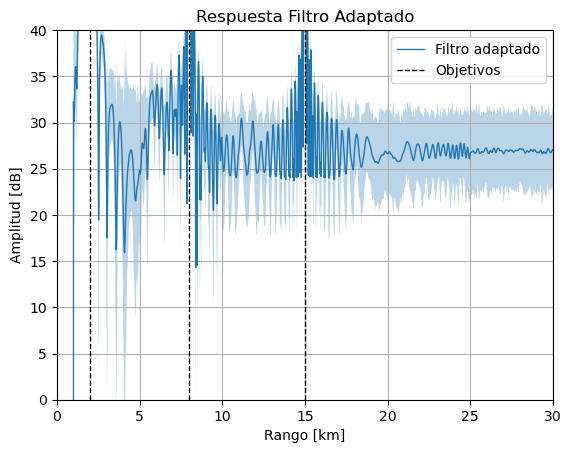

In [53]:
if True:
    Range_Target = [2E3, 8E3, 15E3]
    Nt = [int((2*ii/speed_of_light)*Fs)  for ii in Range_Target]
    MC = 100
    # Señal ruido
    sigma2 = 1 
    Sy = ( np.random.normal(0, 1, (Ndata,MC)) + 1j*np.random.normal(0, 1, (Ndata,MC)) )*np.sqrt(sigma2/2)
    #  Señal eco de objetivo
    SNR = 0
    A = np.sqrt( sigma2*10**(SNR/10) )
    St = np.ones((Ndata,1), dtype='cfloat')
    for ii in Nt:
        St[ii:(ii+Np)] += A*np.reshape(Sx[:Np], (Np,1))
    Sy += St
    # Señal interferencia
    INR = 40
    I = np.sqrt( sigma2*10**(INR/10) ) 
    Sy[:Np,:] = I*np.ones((Np,1))*(1+1j)/np.sqrt(2)
    # Señal ventaneada
    Sy *= np.reshape(W, (Ndata,1))
    # Señal respuesta codificacion parcial
    Sz = np.abs( fftconvolve(Sy, np.conj(np.reshape(Sx[:Np], (Np,1))), mode='full', axes=0) )/(Fs*1E-6)
    Sz = Sz[Np:,:]
    Sz[:len(C),:] *= np.reshape(C, (len(C),1))
    Sz[:N1,:] = np.amin(Sz) 
    # Grafico
    Sz = 20*np.log10(Sz)
    MeanSz = np.mean(Sz, axis=1)
    StdSz = np.std(Sz, axis=1)
    plt.plot(r_y[:-1]*1E-3, MeanSz, color='tab:blue', linewidth=1, label='Filtro adaptado')
    plt.fill_between(r_y[:-1]*1E-3, (MeanSz-3*StdSz), (MeanSz+3*StdSz), alpha=0.3)
    plt.vlines(np.array(Range_Target)*1E-3, 0, 40, colors='k', linestyles='dashed', linewidth=1, label='Objetivos')
    plt.xlim(0, R2*1E-3)
    plt.ylim(0, 40)
    plt.xlabel('Rango [km]')
    plt.ylabel('Amplitud [dB]')
    plt.title('Respuesta Filtro Adaptado')
    plt.legend()
    plt.grid(True)
    plt.show()

## Conclusiones
* El método PPC es una técnica simple de compressión de pulsos con modulación en frecuencia que permite detectar objetivos ubicados en la región de rango ciego, reduciendo el rango mínimo efectivo del radar.
* La viabilidad del método depende de relaciones de compromiso entre la resolución deseada, el ancho de banda de la señal transmitida y el rango mínimo.

## Trabajo Futuro
* Validar los resultado con datos reales.
* Desarrollo analítico de la resolución y calibración para señales chirp.

## Referencias
1. C.M. Salazar Aquino, B. Cheong, R.D. Palmer, Progressive pulse compression: a novel technique for blind range recovery for solid-state radars, Journal of Atmospheric and Oceanic Technology, vol. 38, issuer 9, pp. 1599-1611, 2021.

## Referencias Relevantes
1. Bharadwaj, N., and V. Chandrasekar, 2012: Wideband waveform design principles for solid-state weather radars. J. Atmos. Oceanic Technol., 29, 14–31.
2. Cheong, B. L., K. Redmond, R. D. Palmer, Y. Zhang, M. Yeary, and T.-Y. Yu, 2013: PX-1000: A solid-state polarimetric X-band weather radar and time-frequency multiplexed waveform for blind range mitigation, IEEE
Trans. Instrum. Meas., 62, 3064–3072.
3. K. V. Mishra, C. M. Nguyen, and V. Chandrasekar, 2010: Implementation of blind zone and range-velocity ambiguity mitigation for solid-state weather radar. 2010 IEEE Radar Conf., Arlington, VA, IEEE, 1434–1438. 